# Produce sequence QC filters and sex calls

This notebook produces the sequence QC filters (`qc_filters.tsv`) and sex calls (`sex_call.tsv`) for a single sample set. Samples that fail, or are close to failing can be examined in detail.

This notebook examines 4 main QC areas:

- Genome coverage
- Sex calling
- Divergence
- Contamination

See the `config` variables in the `Settings` section below. We expect these to be used in the vast majority of sample sets, but we allow flexibility for special exceptions.

Note (Louise Cerdeira): contamination threshold changed for 2%

In [ ]:
!pip install voila-gridstack

In [1]:
# Imports
import pandas as pd
import os
from pathlib import Path
import numpy as np
import yaml
from pyprojroot import here

In [2]:
# bokeh setup
from bokeh.layouts import gridplot
from bokeh.models import Legend, Span
from bokeh.plotting import ColumnDataSource, figure, output_notebook, show

output_notebook()

Loading BokehJS ...

In [3]:
# matplotlib setup
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# Eyeball git repo clone root
here()

RecursionError: maximum recursion depth exceeded while calling a Python object

In [5]:
# Eyeball cwd
Path.cwd()

PosixPath('/home/jovyan')

## Settings

In [43]:
# Set this to the sample set.
# This notebook should be placed under a tracking folder with the same name. (See the `expected_cwd` check below.)
sample_set = "1244-VO-GH-YAWSON-VMF00051"

In [44]:
repo_clone_path = here()

In [45]:
tracking_dir = repo_clone_path / "tracking" / sample_set

In [46]:
config = {
    "sex_call_male": (0.4, 0.6),
    "sex_call_female": (0.8, 1.2),
    "min_frac_genome_covered": 0.5,
    "min_median_cov": 10,
    "max_pc_contam": 2,
    "max_divergence": 0.04,
}

In [47]:
# define colors
sex_colors = {"M": "firebrick", "F": "lightblue", "UKN": "green"}
qc_colors = {"FAIL": "red", "PASS": "green"}

In [48]:
## Specify partner metadata column names
# Set to None when the column doesn't exist.
# These will be ignored if the file doesn't exist.
partner_metadata_sex_col_name = "sex"
partner_metadata_species_col_name = "mc"

## Check the current working dir

In [49]:
expected_cwd = tracking_dir / "wgs_sequence_qc"

In [50]:
assert (
    Path.cwd() == expected_cwd
), f"Expected to be in {expected_cwd}\nCurrent dir is {Path.cwd()}"

## Setup

In [51]:
# load and merge sample metadata

derived_samples = pd.read_csv(tracking_dir / "wgs_derived_samples.tsv", sep="\t")

original_samples = pd.read_csv(tracking_dir / "original_samples.tsv", sep="\t")

derived_samples = derived_samples.merge(
    original_samples, on="original_sample_id", how="left"
)

derived_samples.head()

,derived_sample_id,original_sample_id,sanger_sample_id,partner_sample_id,contributor,country,location,year,month
0,VBS19051-5563STDY7800136,VBS19051,5563STDY7800136,WA-0001,Alexander Egyir-Yawson,Ghana,Madina,2017,11
1,VBS19052-5563STDY7800137,VBS19052,5563STDY7800137,WA-0002,Alexander Egyir-Yawson,Ghana,Madina,2017,11
2,VBS19053-5563STDY7800138,VBS19053,5563STDY7800138,WA-0003,Alexander Egyir-Yawson,Ghana,Madina,2017,11
3,VBS19054-5563STDY7800139,VBS19054,5563STDY7800139,WA-0004,Alexander Egyir-Yawson,Ghana,Madina,2017,11
4,VBS19055-5563STDY7800140,VBS19055,5563STDY7800140,WA-0005,Alexander Egyir-Yawson,Ghana,Madina,2017,11


In [52]:
# load QC summary data
qc_summary_path = tracking_dir / "wgs_sequence_qc/qc_summary.tsv"
qc_summary = (
    pd.read_csv(qc_summary_path, sep="\t", index_col=0)
    .merge(derived_samples, on="derived_sample_id")
    .set_index("derived_sample_id")
)

In [53]:
# make sex call
def make_sex_call(x, cfg):

    male_lb, male_ub = cfg["sex_call_male"]
    female_lb, female_ub = cfg["sex_call_female"]
    if male_lb <= x < male_ub:
        return "M"
    elif female_lb <= x < female_ub:
        return "F"
    else:
        return "UKN"

In [54]:
qc_summary["ratio_X_3L"] = qc_summary.eval("mode_cov_X / mode_cov_3L")
qc_summary["ratio_X_3R"] = qc_summary.eval("mode_cov_X / mode_cov_3R")

qc_summary["sex_call"] = qc_summary.ratio_X_3R.apply(make_sex_call, args=(config,))

qc_summary.sex_call.value_counts()

F      920
M        3
UKN      1
Name: sex_call, dtype: int64

In [55]:
# apply filters
# True is pass
qc_summary["FILTER_frac_genome_cov"] = (
    qc_summary.frac_gen_cov >= config["min_frac_genome_covered"]
)

qc_summary["FILTER_median_cov"] = qc_summary.median_cov >= config["min_median_cov"]

qc_summary["FILTER_contamination"] = qc_summary.pc_contam < config["max_pc_contam"]

qc_summary["FILTER_nosexcall"] = qc_summary.sex_call != "UKN"

qc_summary["FILTER_divergence"] = qc_summary.divergence < config["max_divergence"]

In [56]:
# convenience variables - N.B., do this before setting up categoricals
filter_cols = [x for x in qc_summary.columns if x.startswith("FILTER_")]
pass_samples = qc_summary[filter_cols].all(axis=1)

# setup categoricals
qc_summary["sex_call"] = pd.Categorical(
    qc_summary.sex_call, categories=sex_colors.keys()
)
for x in qc_summary.columns:
    if x.startswith("FILTER_"):
        qc_summary[x] = pd.Categorical(qc_summary[x], categories=[True, False])
        qc_summary[x] = qc_summary[x].cat.rename_categories(
            {True: "PASS", False: "FAIL"}
        )

qc_summary.head()

,mean_cov,median_cov,modal_cov,mean_cov_2L,median_cov_2L,mode_cov_2L,mean_cov_2R,median_cov_2R,mode_cov_2R,mean_cov_3L,...,year,month,ratio_X_3L,ratio_X_3R,sex_call,FILTER_frac_genome_cov,FILTER_median_cov,FILTER_contamination,FILTER_nosexcall,FILTER_divergence
derived_sample_id,,,,,,,,,,,,,,,,,,,,,
VBS19051-5563STDY7800136,39.45,40,40,39.46,40,40,39.75,40,41,38.37,...,2017,11,1.025000,1.025000,F,PASS,PASS,PASS,PASS,PASS
VBS19052-5563STDY7800137,51.89,52,53,51.92,53,53,52.49,53,54,50.40,...,2017,11,1.038462,1.018868,F,PASS,PASS,PASS,PASS,PASS
VBS19053-5563STDY7800138,33.60,34,34,33.71,34,34,33.87,34,35,32.82,...,2017,11,1.000000,1.000000,F,PASS,PASS,PASS,PASS,PASS
VBS19054-5563STDY7800139,5.13,4,3,5.08,4,3,5.09,4,3,5.11,...,2017,11,1.000000,1.000000,F,PASS,FAIL,FAIL,PASS,PASS
VBS19055-5563STDY7800140,35.63,36,36,35.71,36,36,36.02,36,37,34.76,...,2017,11,1.000000,1.000000,F,PASS,PASS,FAIL,PASS,PASS


In [57]:
def bokeh_2d_legend(
    xvar,
    yvar,
    xlab,
    ylab,
    hue_var,
    colors,
    hlines=None,
    vlines=None,
    tooltips=None,
    title="QC plot",
):

    fig = figure(
        plot_width=500,
        plot_height=400,
        tooltips=tooltips,
        toolbar_location="right",
        title=title,
    )
    grp = qc_summary.groupby(hue_var)
    legend_l = []
    for desc, df in grp:
        source = ColumnDataSource(df)
        q = fig.circle(
            xvar,
            yvar,
            source=source,
            line_color="black",
            line_width=0.5,
            size=6,
            fill_color=colors[desc],
        )
        legend_l.append(q)

    if hlines is not None:
        for x in hlines:
            vline = Span(
                location=x,
                dimension="width",
                line_color="black",
                line_dash="dashed",
                line_width=1.0,
            )

            fig.renderers.extend([vline])

    if vlines is not None:
        for x in vlines:
            vline = Span(
                location=x,
                dimension="height",
                line_color="black",
                line_dash="dashed",
                line_width=1.5,
            )

            fig.renderers.extend([vline])

    legend = Legend(
        items=[(str(a), [b]) for a, b in zip(grp.groups.keys(), legend_l)],
        location=(0, 0),
    )

    fig.add_layout(legend, "right")
    fig.xaxis.axis_label = xlab
    fig.yaxis.axis_label = ylab
    show(fig)

In [58]:
def mpl_2d_legend(
    xvar, yvar, xlab, ylab, hue_var, colors, hlines=None, vlines=None, title="QC plot"
):

    fig, ax = plt.subplots(figsize=(7, 8))

    sns.despine(ax=ax)
    ax.grid(True)
    ax.set_title(title)

    grp = qc_summary.groupby(hue_var)
    legend_l = []
    for desc, df in grp:
        q = ax.scatter(
            df[xvar],
            df[yvar],
            edgecolors="black",
            c=colors[desc],
            lw=0.5,
            s=30,
            label=desc,
        )
        legend_l.append(q)

    if hlines:
        for hline in hlines:
            ax.axhline(hline, linestyle="--", color="k")
    if vlines:
        for vline in vlines:
            ax.axvline(vline, linestyle="--", color="k")

    ax.legend()

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

In [59]:
def plot_2d(
    xvar,
    yvar,
    xlab,
    ylab,
    hue_var,
    colors,
    hlines=None,
    vlines=None,
    tooltips=None,
    title="QC plot",
):
    bokeh_2d_legend(
        xvar,
        yvar,
        xlab,
        ylab,
        hue_var,
        colors,
        hlines=hlines,
        vlines=vlines,
        tooltips=tooltips,
        title=title,
    )
    mpl_2d_legend(
        xvar,
        yvar,
        xlab,
        ylab,
        hue_var,
        colors,
        hlines=hlines,
        vlines=vlines,
        title=title,
    )

In [60]:
qc_summary.columns

Index(['mean_cov', 'median_cov', 'modal_cov', 'mean_cov_2L', 'median_cov_2L',
       'mode_cov_2L', 'mean_cov_2R', 'median_cov_2R', 'mode_cov_2R',
       'mean_cov_3L', 'median_cov_3L', 'mode_cov_3L', 'mean_cov_3R',
       'median_cov_3R', 'mode_cov_3R', 'mean_cov_X', 'median_cov_X',
       'mode_cov_X', 'frac_gen_cov', 'divergence', 'pc_contam', 'LLR',
       'original_sample_id', 'sanger_sample_id', 'partner_sample_id',
       'contributor', 'country', 'location', 'year', 'month', 'ratio_X_3L',
       'ratio_X_3R', 'sex_call', 'FILTER_frac_genome_cov', 'FILTER_median_cov',
       'FILTER_contamination', 'FILTER_nosexcall', 'FILTER_divergence'],
      dtype='object')

## Genome coverage

This section identifies samples that fail to meet minumum coverage requirements for inclusion. 

In [61]:
# This defines what is displayed when the mouse hovers over a point.
# The @ values correspond to values in the table.
tooltips_coverage = [
    ("ID", "@derived_sample_id"),
    ("median coverage", "@median_cov"),
    ("frac covered", "@frac_gen_cov"),
    ("filter frac covered", "@FILTER_frac_genome_cov"),
    ("filter median coverage", "@FILTER_median_cov"),
]

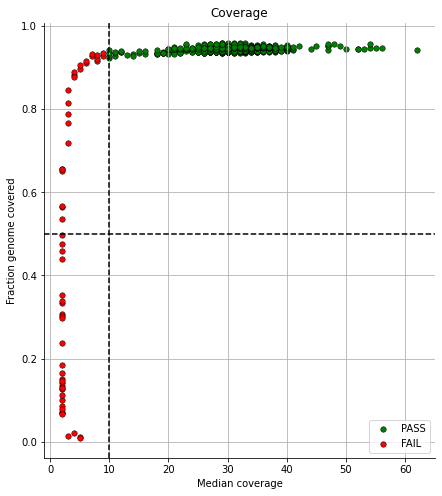

In [62]:
plot_2d(
    "median_cov",
    "frac_gen_cov",
    "Median coverage",
    "Fraction genome covered",
    "FILTER_median_cov",
    qc_colors,
    vlines=[config["min_median_cov"]],
    hlines=[config["min_frac_genome_covered"]],
    tooltips=tooltips_coverage,
    title="Coverage",
)

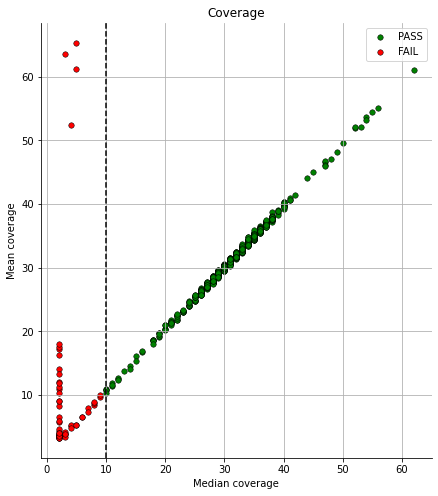

In [63]:
plot_2d(
    "median_cov",
    "mean_cov",
    "Median coverage",
    "Mean coverage",
    "FILTER_median_cov",
    qc_colors,
    vlines=[config["min_median_cov"]],
    tooltips=tooltips_coverage,
    title="Coverage",
)

## Sex calling

To make a sex call we use the ratio of the modal coverage on X to 3R. Females should have broadly similar coverage on both chromosomes (a ratio of ~1.0), while we expect males to have about half the coverage on X (a ratio of about 0.5). In practice, due to higher divergence on X, the ratios are lower. 

Previously instead of modal coverage we used mean. The problem with using mean is that some samples have highly skewed coverage distributions on the X (especially WGA samples). This leads to higher than expected X:3R ratios, which may be enough to push a male WGA into female classification.

In [64]:
qc_summary.columns

Index(['mean_cov', 'median_cov', 'modal_cov', 'mean_cov_2L', 'median_cov_2L',
       'mode_cov_2L', 'mean_cov_2R', 'median_cov_2R', 'mode_cov_2R',
       'mean_cov_3L', 'median_cov_3L', 'mode_cov_3L', 'mean_cov_3R',
       'median_cov_3R', 'mode_cov_3R', 'mean_cov_X', 'median_cov_X',
       'mode_cov_X', 'frac_gen_cov', 'divergence', 'pc_contam', 'LLR',
       'original_sample_id', 'sanger_sample_id', 'partner_sample_id',
       'contributor', 'country', 'location', 'year', 'month', 'ratio_X_3L',
       'ratio_X_3R', 'sex_call', 'FILTER_frac_genome_cov', 'FILTER_median_cov',
       'FILTER_contamination', 'FILTER_nosexcall', 'FILTER_divergence'],
      dtype='object')

In [65]:
# This defines what is displayed when the mouse hovers over a point.
# The @ values correspond to values in the table.
tooltips_sex = [
    ("ID", "@derived_sample_id"),
    ("divergence", "@divergence"),
    ("X:3R mode", "@ratio_X_3R"),
    ("filter no sex call", "@FILTER_nosexcall"),
]

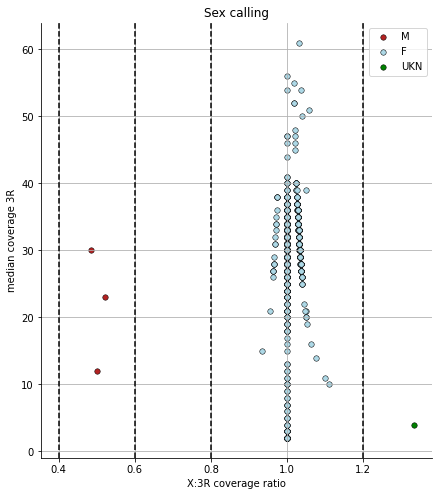

In [66]:
plot_2d(
    "ratio_X_3R",
    "median_cov_3R",
    "X:3R coverage ratio",
    "median coverage 3R",
    "sex_call",
    sex_colors,
    vlines=config["sex_call_male"] + config["sex_call_female"],
    tooltips=tooltips_sex,
    title="Sex calling",
)

## Divergence

We have applied a filter to remove any highly diverged samples that may be Anophelines other than gambiae, coluzzii or arabiensis.

/home/conda/store/bd139c27c8b00d6d446deb753e62ee8442f175089356f9909f191dbb37124368-binder-v3.0.0/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


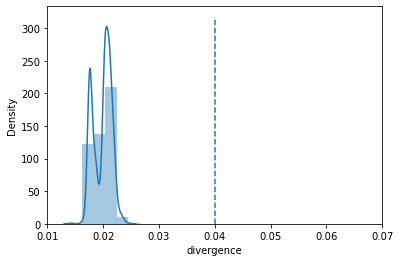

In [67]:
fig, ax = plt.subplots()
xmin = 0.01
xmax = 0.07
nbins = 30
plt.xlim(xmin, xmax)
bins = np.linspace(xmin, xmax, nbins)
sns.distplot(qc_summary["divergence"], ax=ax, bins=bins)
ax.vlines([config["max_divergence"]], *ax.get_ylim(), linestyle="--")

## Contamination

In [68]:
# This defines what is displayed when the mouse hovers over a point.
# The @ values correspond to values in the table.
tooltips_contamination = [
    ("ID", "@derived_sample_id"),
    ("contamination %", "@pc_contam"),
    ("LLR", "@LLR"),
    ("median coverage", "@median_cov"),
    ("frac covered", "@frac_gen_cov"),
    ("filter contamination", "@FILTER_contamination"),
]

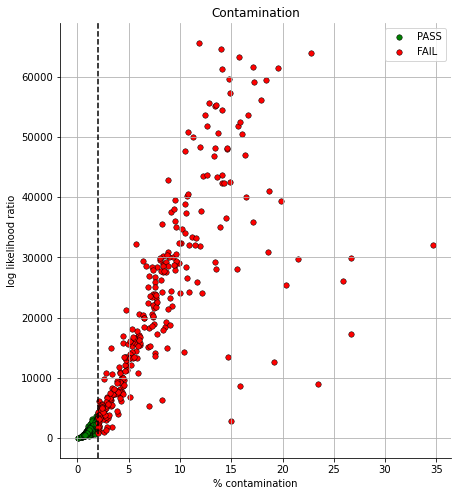

In [69]:
plot_2d(
    "pc_contam",
    "LLR",
    "% contamination",
    "log likelihood ratio",
    "FILTER_contamination",
    qc_colors,
    vlines=[config["max_pc_contam"]],
    tooltips=tooltips_contamination,
    title="Contamination",
)

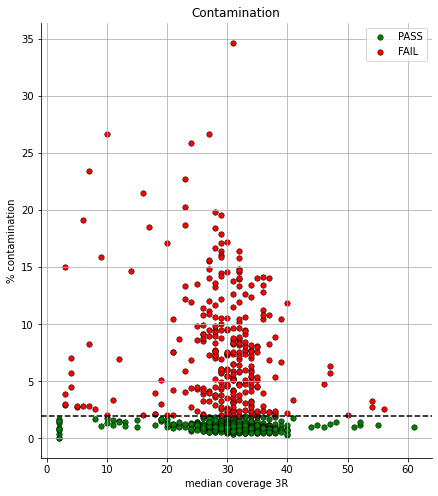

In [70]:
plot_2d(
    "median_cov_3R",
    "pc_contam",
    "median coverage 3R",
    "% contamination",
    "FILTER_contamination",
    qc_colors,
    hlines=[config["max_pc_contam"]],
    tooltips=tooltips_contamination,
    title="Contamination",
)

We are losing a lot of samples to contamination, investigate a little...

In [71]:
from IPython.display import HTML, display


def display_ab(sample_id):
    html = HTML(f"""
        <h4>{sample_id}</h4>
        <img width="400" height="400" src="https://storage.cloud.google.com/vo_agam_production/v3.x/curation/{sample_set}/summary_stats/{sample_id}.allele_balance.png"/>""")
    display(html)

In [72]:
for sample in (
    qc_summary[(qc_summary.pc_contam >= 3.5) & (qc_summary.pc_contam < 4.5)]
    .head()
    .itertuples()
    display_ab(sample.Index)

SyntaxError: invalid syntax (4228994210.py, line 5)

In [73]:
for sample in (
    qc_summary[(qc_summary.pc_contam >= 4.5) & (qc_summary.pc_contam < 5.5)]
    .head()
    .itertuples()
):
    display_ab(sample.Index)

In [74]:
for sample in (
    qc_summary[(qc_summary.pc_contam >= 5.5) & (qc_summary.pc_contam < 6.5)]
    .head()
    .itertuples()
):
    display_ab(sample.Index)

In [40]:
for sample in (
    qc_summary[(qc_summary.pc_contam >= 6.5) & (qc_summary.pc_contam < 7.5)]
    .head()
    .itertuples()
):
    display_ab(sample.Index)

In [39]:
for sample in (
    qc_summary[(qc_summary.pc_contam >= 7.5) & (qc_summary.pc_contam < 8.5)]
    .head()
    .itertuples()
):
    display_ab(sample.Index)

In [40]:
for sample in (
    qc_summary[(qc_summary.pc_contam >= 8.5) & (qc_summary.pc_contam < 10)]
    .head()
    .itertuples()
):
    display_ab(sample.Index)

In [75]:
for sample in qc_summary[(qc_summary.pc_contam >= 10)].head().itertuples():
    display_ab(sample.Index)

In [76]:
qc_summary.pc_contam.hist(bins=np.arange(0, 4, 10, 0.5));

In [77]:
((qc_summary.pc_contam >= 2) & ((qc_summary.pc_contam <= 4.5 ))).sum()

In [78]:
((qc_summary.pc_contam >= 4.5) & ((qc_summary.pc_contam < 6.5))).sum()

In [79]:
((qc_summary.pc_contam >= 6.5) & ((qc_summary.pc_contam < 7.5))).sum()

In [80]:
(qc_summary.pc_contam >= 10).sum()

## Excluded samples

In [81]:
qc_s = qc_summary.loc[~pass_samples].T

In [82]:
# compression_opts = dict(method='zip',
#                        archive_name='out.csv')
#qc_s = df.to_csv("out.csv", index=True)

In [83]:
# Number of samples that fail each filter *in parallel*
print("Number of samples that fail each filter *in parallel*:")
(qc_summary.loc[~pass_samples][filter_cols] == "FAIL").sum(axis=0)

In [84]:
# Number of samples that fail each filter *in series*
df = qc_summary[filter_cols] == "FAIL"
print("Number of samples that fail each filter *in series*:")
(df.cummax(axis=1).cumsum(axis=1) == 1).sum(axis=0)

In [85]:
# Number of samples that fail any of the filters
b = (qc_summary[filter_cols] == "FAIL").any(axis=1).sum()
print("Number of samples that fail any of the filters:", b)

In [86]:
# Number of samples that pass all of the filters
a = (qc_summary[filter_cols] == "PASS").all(axis=1).sum()
print("Number of samples that pass all of the filters:", a)

In [87]:
# write out decision
qc_summary[filter_cols].to_csv(
    tracking_dir / "wgs_sequence_qc/qc_filters.tsv", sep="\t", index=True
)

In [88]:
qc_summary[["sex_call"]].to_csv(
    tracking_dir / "wgs_sequence_qc/sex_call.tsv", sep="\t", index=True
)